# MultiClass Text Classification with Multiple Estimators and HyperparameterOptimization

In [1]:
"""
cd .\03multiclass-classification\
jupyter nbconvert --to markdown multiclass.ipynb --output README.md
"""


## Problem Formulation

There are lots of applications of text classification in the commercial world. For example, news stories are typically organized by topics; content or products are often tagged by categories; users can be classified into cohorts based on how they talk about a product or brand online …


This project covers multiclass classification on a customer complaints dataset.

[customer-complaints-dataset](https://catalog.data.gov/dataset/consumer-complaint-database)

**Problem Formulation:**

Given a new complaint comes in, we want to assign it to one of 12 categories. The classifier makes the assumption that each new complaint is assigned to one and only one category. This is multi-class text classification problem. I can’t wait to see what we can achieve!

For this project, we need only two columns — “Product” and “Consumer complaint narrative”.

- Input: Consumer_complaint_narrative
  
Example: “ I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements"

- Output: product
Example: Credit reporting


After preprocessing the data we will build multiple models with different estimator and different hyperparemeters to find the best performing model.

## Load the Data

### Get the data ready

In [53]:
import pandas as pd
import numpy as np

In [54]:

# dataset = pd.read_csv('Consumer_Complaints_min.csv')
dataset = pd.read_csv('Consumer_Complaints.csv')
# Select only the Product and Consumer Complaint columns  
dataset= dataset[['Product', 'Consumer Complaint']]
dataset.head()


,Product,Consumer Complaint
0,Mortgage,NaN
1,Credit reporting,I have outdated information on my credit repor...
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...
3,Credit card,NaN
4,Debt collection,NaN


In [55]:
# Drop rows with missing labels
dataset.dropna(subset=["Consumer Complaint"], inplace=True)
# Rename column
dataset.columns = ['Product', 'ConsumerComplaint']
dataset.head()

,Product,ConsumerComplaint
1,Credit reporting,I have outdated information on my credit repor...
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...
7,Credit reporting,An account on my credit report has a mistaken ...
12,Debt collection,This company refuses to provide me verificatio...
16,Debt collection,This complaint is in regards to Square Two Fin...


In [56]:
# Only include the following products
dataset = dataset[dataset['Product'].isin(['Credit reporting',
                                           'Debt collection',
                                          'Mortgage',
                                           'Credit Card',
                                           'Student loan',
                                           'Bank account or service'])]

# Print the top 5 rows
dataset.head()


,Product,ConsumerComplaint
1,Credit reporting,I have outdated information on my credit repor...
7,Credit reporting,An account on my credit report has a mistaken ...
12,Debt collection,This company refuses to provide me verificatio...
16,Debt collection,This complaint is in regards to Square Two Fin...
25,Mortgage,Started the refinance of home mortgage process...


### Labels Encoding

In [57]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [58]:
# Assigning numerical values and storing in another column
dataset['category_id'] = labelencoder.fit_transform(dataset['Product'])
dataset.head()

,Product,ConsumerComplaint,category_id
1,Credit reporting,I have outdated information on my credit repor...,1
7,Credit reporting,An account on my credit report has a mistaken ...,1
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2
25,Mortgage,Started the refinance of home mortgage process...,3


## Text Preprocessing

### How clean is the text?

In [59]:
dataset["ConsumerComplaint"].to_list()[:2]

['I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements',
 'An account on my credit report has a mistaken date. I mailed in a debt validation letter to allow XXXX to correct the information. I received a letter in the mail, stating that Experian received my correspondence and found it to be " suspicious \'\' and that " I did n\'t write it \'\'. Experian \'s letter is worded to imply that I am incapable of writing my own letter. I was deeply offended by this implication. \nI called Experian to figure out why my letter was so suspicious. I spoke to a representative who was incredibly unhelpful, She did not effectively answer any questions I asked of her, and she kept ignoring what I was saying regarding the offensive letter and my dispute process. I feel the representative did what she wanted to do, and I am not satisfied. It is STILL not clea

### Run data through cleanup function

In [61]:
import nltk
from nltk.corpus import stopwords
import re

# Lets do some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    text = text.lower()  # lowercase text
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = text.replace('x', '')  # Remove the XXXX values
    text = REMOVE_NUM.sub('', text)
    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text)
    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text


dataset["ConsumerComplaint"] = dataset["ConsumerComplaint"].apply(clean_text)


### How clean is the text now?


In [62]:
dataset["ConsumerComplaint"].to_list()[:2]

['outdated information credit report previously disputed yet removed information seven years old meet credit reporting requirements',
 'account credit report mistaken date mailed debt validation letter allow correct information received letter mail stating eperian received correspondence found suspicious nt write eperian letter worded imply incapable writing letter deeply offended implication called eperian figure letter suspicious spoke representative incredibly unhelpful effectively answer questions asked kept ignoring saying regarding offensive letter dispute process feel representative wanted satisfied still clear received letter typed letter signed letter paid mail letter yet eperian willfully disregarded lawful request disgusted entire situation would like dispute handled appropriately would like eperian representative contact give real eplanation letter']

## Plotting the data

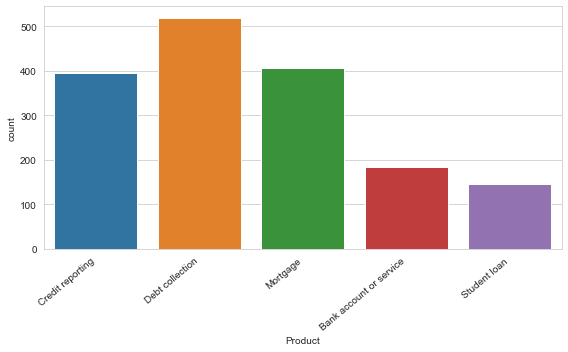

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Product', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()


## Split the data into training and test sets


In [64]:
# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
dataset = dataset.sample(frac=1)
dataset.head()


,Product,ConsumerComplaint,category_id
4471,Debt collection,debt incurred medical charges auto accident at...,2
9431,Credit reporting,clue anything reported credit report tried app...,1
2661,Debt collection,service television internet phone townhome own...,2
6882,Credit reporting,account number called billing dont billing rea...,1
3546,Debt collection,attached letter received debt collector please...,2


In [65]:
# Split into X/y
from sklearn.model_selection import train_test_split, cross_val_score

x = dataset["ConsumerComplaint"]
y = dataset["category_id"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1320,)
(331,)
(1320,)
(331,)


## Vectorization: Convert text features to numeric

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features
cv2 = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2',
                      ngram_range=(1, 2), stop_words='english')

X_traincv = cv2.fit_transform(x_train)
x_testcv = cv2.transform(x_test)
print(X_traincv.toarray())


[[0.         0.10271586 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## Build the model with the best estimator

In [124]:
# Hyperparameter grid RandomizedSearchCV will search over
from termcolor import cprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# ignore ConvergenceWarnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

models = [
    { "model_instance": KNeighborsClassifier(),
      "model_name": "KNeighbors",
      "params": {
          "n_neighbors": [25,30,35,45],
          "weights": ['uniform','distance'],
          "leaf_size": [25,30,35]
        }
    },
    { "model_instance": DecisionTreeClassifier(),
      "model_name": "DecisionTree",
      "params": {
          "criterion": ['gini','entropy'],
          "splitter": ['best','random'],
          "max_depth": [None,90,95,100],
          "max_features": [None, "auto","sqrt","log2"],
          "random_state": [42]
      }
    },
    { "model_instance": MultinomialNB(),
      "model_name":"MultinomialNB",
      "params": {
          "fit_prior": [True, False]    
      }
    },
    { "model_instance": LinearSVC(),
      "model_name": "SVC",
      "params": {
          "loss": ['hinge','squared_hinge'],
          "multi_class": ['ovr', 'crammer_singer'],
          "fit_intercept": [True, False],
          "random_state": [42],
          "max_iter": [900, 1000, 1100]
      }
    },
    { "model_instance": svm.SVC(),
      "model_name": "SVM",
      "params": {
          'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']
      }
    },
    { "model_instance": RandomForestClassifier(),
      "model_name": "RandomForest",
      "params": {
      "criterion": ['gini','entropy'],
      "bootstrap": [True, False],
      "max_depth": [85,90,95,100],
      "max_features": ['sqrt','log2'],
      "n_estimators": [60, 80, 90],
      "random_state": [42]
      }
    },
    { "model_instance": SGDClassifier(),
      "model_name": "SGDClassifier",
      "params": {
          "loss": ['hinge','log','perceptron'], 
          "penalty": ['l2', 'l1'], 
          "alpha": [0.0001, 0.0003, 0.0010],
          "early_stopping": [True],
          "max_iter": [1000, 1500],
          "random_state": [42]
      }
    }
]


scores = []
highest_acc = 0
best_model = None


for model in models:
  


  # Create a based model
  model_instance = model["model_instance"]
  model_name = model["model_name"]
  print("Running Model:",end="")
  cprint(model_name, "green")
  # Instantiate the grid search model
  classifier = GridSearchCV(estimator=model_instance, param_grid=model["params"],
                            cv = 3, n_jobs = 1)
  
  # Fit the model
  classifier.fit(X_traincv, y_train);
  
  # Make a prediction on the test split to find model accuracy
  predicted = classifier.predict(x_testcv)
  acc = accuracy_score(predicted, y_test)
  # If model have the highest accuracy, it's out best model
  if acc > highest_acc:
    highest_acc = acc
    best_model = classifier

  scores.append({
    "model":model_name,
    "training_best_score": classifier.best_score_,
    "test_best_score": acc,
    "best_params": classifier.best_params_
  })
  
  print("Best Training Score:",end="")
  cprint(f"{round(classifier.best_score_*100,2)}%  ", "cyan", end="")
  print("Best Test Score:",end="")
  cprint(f"{round(acc*100,2)}%  ", "cyan")

  print("Best Params:",end="")
  cprint(classifier.best_params_,"yellow")

print("\nBest Model:",end="")
cprint(best_model.best_estimator_,"red")


Running Model:KNeighbors
Best Training Score:86.14%  Best Test Score:84.59%  
Best Params:{'leaf_size': 25, 'n_neighbors': 30, 'weights': 'uniform'}
Running Model:DecisionTree
Best Training Score:72.95%  Best Test Score:73.11%  
Best Params:{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'random_state': 42, 'splitter': 'best'}
Running Model:MultinomialNB
Best Training Score:86.21%  Best Test Score:86.1%  
Best Params:{'fit_prior': False}
Running Model:SVC
Best Training Score:87.35%  Best Test Score:88.22%  
Best Params:{'fit_intercept': False, 'loss': 'hinge', 'max_iter': 900, 'multi_class': 'ovr', 'random_state': 42}
Running Model:SVM
Best Training Score:85.45%  Best Test Score:86.1%  
Best Params:{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Running Model:RandomForest
Best Training Score:85.61%  Best Test Score:85.5%  
Best Params:{'bootstrap': False, 'criterion': 'gini', 'max_depth': 85, 'max_features': 'sqrt', 'n_estimators': 80, 'random_state': 42}
Running Model:SGDClassif

In [125]:
df = pd.DataFrame(scores)
df

,model,training_best_score,test_best_score,best_params
0,KNeighbors,0.861364,0.845921,"{'leaf_size': 25, 'n_neighbors': 30, 'weights'..."
1,DecisionTree,0.729545,0.731118,"{'criterion': 'gini', 'max_depth': None, 'max_..."
2,MultinomialNB,0.862121,0.861027,{'fit_prior': False}
3,SVC,0.873485,0.882175,"{'fit_intercept': False, 'loss': 'hinge', 'max..."
4,SVM,0.854545,0.861027,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}"
5,RandomForest,0.856061,0.854985,"{'bootstrap': False, 'criterion': 'gini', 'max..."
6,SGDClassifier,0.873485,0.900302,"{'alpha': 0.0003, 'early_stopping': True, 'los..."


In [126]:
df['test_best_score'].max()


0.9003021148036254

In [127]:
highest_acc

0.9003021148036254

In [128]:
best_model.best_estimator_

SGDClassifier(alpha=0.0003, early_stopping=True, loss='log', random_state=42)

## Plotting each models performance

<AxesSubplot:xlabel='model', ylabel='test_best_score'>

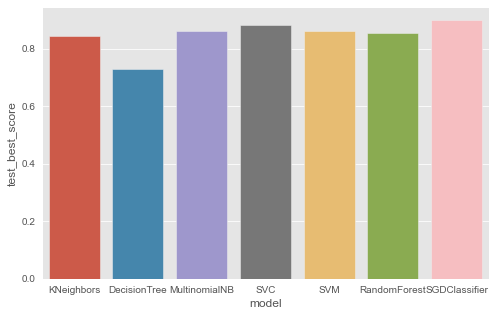

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(8, 5))
sns.barplot(x='model', y='test_best_score', data=df)


## Evaluating the model and make predictions using the Best Model


In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict


Now we make predictions using the test data to see how the model performs



In [132]:
predicted = best_model.predict(x_testcv)
evaluate_preds(y_test, predicted)


Acc: 90.03%
Precision: 0.90
Recall: 0.90
F1 score: 0.90


{'accuracy': 0.9, 'precision': 0.9, 'recall': 0.9, 'f1': 0.9}

Let's create a Classification report

In [133]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted,
                                    target_names=dataset['Product'].unique()))


                         precision    recall  f1-score   support

        Debt collection       0.86      0.92      0.89        39
       Credit reporting       0.91      0.86      0.88        80
               Mortgage       0.87      0.90      0.88        97
           Student loan       0.93      0.96      0.94        94
Bank account or service       1.00      0.76      0.86        21

               accuracy                           0.90       331
              macro avg       0.91      0.88      0.89       331
           weighted avg       0.90      0.90      0.90       331



- `Accuracy` is a good measure to start with if all classes are balanced (e.g. same amount of samples which are labelled with 0 or 1).
- `Precision and recall` become more important when classes are imbalanced. If false positive predictions are worse than false negatives, aim for higher precision. If false negative predictions are worse than false positives, aim for higher recall.
- `F1-score` is a combination of precision and recall.


And finally a Confusion Matrix



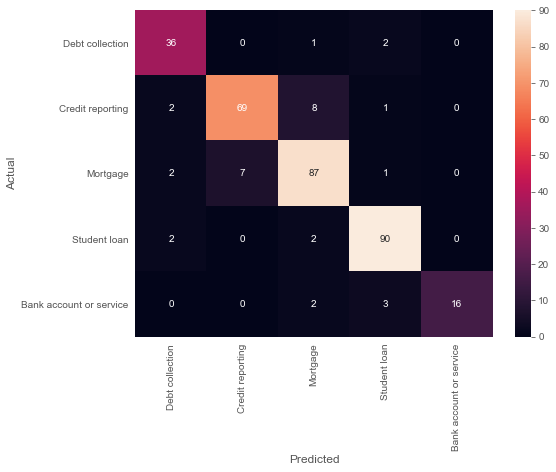

In [134]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## Let's make a prediction

In [137]:
inputStr = cv2.transform(["I need to finance my student loan please"])
results = best_model.predict(inputStr)

print(f'Product category id: {results[0]}')
print(f'Product Name: { labelencoder.inverse_transform([results[0]])[0] }')

Product category id: 4
Product Name: Student loan


## Resources

- [https://www.jeansnyman.com/posts/multi-class-text-classification-with-scikit-learn/](https://www.jeansnyman.com/posts/multi-class-text-classification-with-scikit-learn/)
- [https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f)
- [https://medium.com/@armandj.olivares/a-basic-nlp-tutorial-for-news-multiclass-categorization-82afa6d46aa5](https://medium.com/@armandj.olivares/a-basic-nlp-tutorial-for-news-multiclass-categorization-82afa6d46aa5)